In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import k_means
from scipy.spatial.distance import cdist
from scipy.interpolate import splprep, splev
from scipy.optimize import brent

In [16]:
#%% load data
# [cid, m, n, t, x, y, z]
rpts = np.load('rpoints.npy')
df = pd.DataFrame(rpts, columns=['cid', 'm', 'n', 't', 'x', 'y', 'z'])
df0 = df[df.m == 0]
pts = df0[['n', 't']].to_numpy()

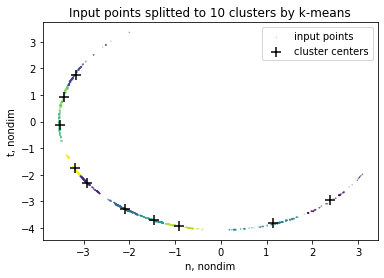

In [14]:
#%% clustering

Nclusters = 10
nt_centers, labels, _ = k_means(pts, Nclusters)
#nt_centers = df0.groupby(labels)[['n', 't']].mean().to_numpy()

plt.title(f'Input points splitted to {Nclusters} clusters by k-means')
plt.scatter(df0.n, df0.t, c=labels, s=0.1, alpha=0.5, label='input points')
plt.scatter(*nt_centers.T, marker='+', c='k', s=100, label='cluster centers')
plt.xlabel('n, nondim')
plt.ylabel('t, nondim')
plt.legend()
plt.show()

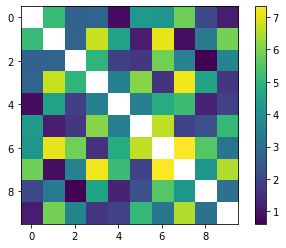

In [7]:
#%% distance matrix for cluster centers
D = cdist(nt_centers, nt_centers)  # distances between cluster centers
start = np.unravel_index(np.argmax(D), D.shape)  # index of starting cluster center
np.fill_diagonal(D, np.inf)

plt.imshow(D)
plt.colorbar()
plt.show()

In [8]:
#%%

def build_path(D, start):
    """
    Build path trough all nodes using minimum distance stepping
    :param D: distance matrix
    :param start: index of starting node
    :return: path
    """
    visited = [start]
    dist = [0]
    n = D.shape[0]
    while len(visited) < n:
        current = visited[-1]
        next = np.argmin(D[current])
        while next in visited:
            D[current, next] = np.inf
            D[next, current] = np.inf
            next = np.argmin(D[current])
        dist.append(D[current, next])
        D[current, next] = np.inf
        D[next, current] = np.inf
        visited.append(next)
    return np.array(visited), np.array(dist)

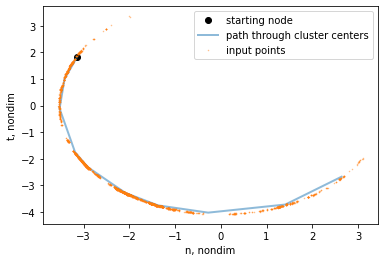

In [9]:
#%% building path through cluster centers

# starting node choice need to be done clever
start_node = start[1]
path, dist = build_path(D.copy(), start_node)

if dist.max() > 2 * dist.mean():
    start_node = path[np.argmax(dist)]
    path, dist = build_path(D.copy(), start_node)

plt.plot(nt_centers[start_node, 0], nt_centers[start_node, 1], 'ok', label='starting node')
plt.plot(nt_centers[path, 0], nt_centers[path, 1], alpha=0.5, lw=2, label='path through cluster centers')
plt.plot(*pts.T, '.', label='input points', ms=1, alpha=0.5)
plt.xlabel('n, nondim')
plt.ylabel('t, nondim')
plt.legend()
plt.show()

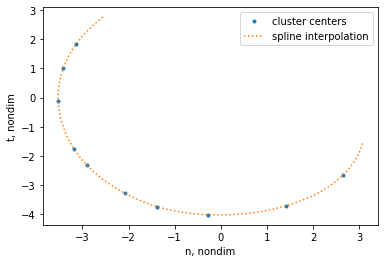

In [10]:
#%% interpolation using cluster centers

rough_tck, rough_u = splprep(nt_centers[path].T, s=0, k=3)
add_pts = splev(np.linspace(-0.1, 1.1, 200), rough_tck)

plt.plot(*nt_centers[path].T, '.', label='cluster centers')
plt.plot(*add_pts, ':', label='spline interpolation')

plt.xlabel('n, nondim')
plt.ylabel('t, nondim')
plt.legend()
plt.show()

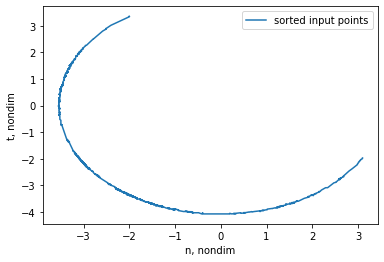

In [27]:
#%% project input points onto cluster centers spline

vals = np.empty(pts.shape[0])
for i in range(pts.shape[0]):
    # _, v = spl_rough.get_closest_point(pts[i], ret_l=True)
    p = pts[i]
    cidx = np.where(path == labels[i])[0][0]
    v0 = rough_u[cidx]
    v = brent(lambda l: np.sum((splev(l, rough_tck) - p) ** 2),
              brack=(v0 - 0.05, v0 + 0.05),
              tol=1e-5)
    vals[i] = v

idx = np.argsort(vals)
plt.plot(*pts[idx].T, label='sorted input points')

plt.xlabel('n, nondim')
plt.ylabel('t, nondim')
plt.legend()
plt.show()

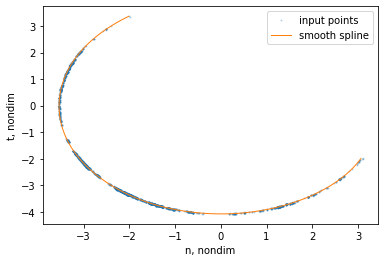

In [12]:
#%% create smooth spline

u = vals[idx]
interp_tck, _ = splprep(pts[idx].T, u=u, k=3, s=0)
smooth_tck, _ = splprep(pts[idx].T, u=u, k=3, s=0.3)
uu = np.linspace(u.min(), u.max(), 1000)
smooth_pts = splev(uu, smooth_tck)
interp_pts = splev(uu, interp_tck)

plt.plot(*pts[idx].T, '.', alpha=0.25, ms=2, label='input points')
plt.plot(*smooth_pts, '-', lw=1, label='smooth spline')
#plt.plot(*interp_pts, '-', lw=1, alpha=0.4, label='interp spline')
plt.xlabel('n, nondim')
plt.ylabel('t, nondim')
plt.legend()
plt.show()

In [19]:
def function(rpts):
    df = pd.DataFrame(rpts, columns=['cid', 'm', 'n', 't', 'x', 'y', 'z'])
    df0 = df[df.m == 0]
    pts = df0[['n', 't']].to_numpy()
    
    Nclusters = 10
    nt_centers, labels, _ = k_means(pts, Nclusters)

    D = cdist(nt_centers, nt_centers)  # distances between cluster centers
    start = np.unravel_index(np.argmax(D), D.shape)  # index of starting cluster center
    np.fill_diagonal(D, np.inf)
    
    start_node = start[1]
    path, dist = build_path(D.copy(), start_node)

    if dist.max() > 2 * dist.mean():
        start_node = path[np.argmax(dist)]
        path, dist = build_path(D.copy(), start_node)
        
    rough_tck, rough_u = splprep(nt_centers[path].T, s=0, k=3)
    add_pts = splev(np.linspace(-0.1, 1.1, 200), rough_tck)
    
    vals = np.empty(pts.shape[0])
    for i in range(pts.shape[0]):
        p = pts[i]
        cidx = np.where(path == labels[i])[0][0]
        v0 = rough_u[cidx]
        v = brent(lambda l: np.sum((splev(l, rough_tck) - p) ** 2),
                  brack=(v0 - 0.05, v0 + 0.05),
                  tol=1e-5)
        vals[i] = v
    idx = np.argsort(vals)
    
    u = vals[idx]
    interp_tck, _ = splprep(pts[idx].T, u=u, k=3, s=0)
    smooth_tck, _ = splprep(pts[idx].T, u=u, k=3, s=0.3)
    uu = np.linspace(u.min(), u.max(), 1000)
    smooth_pts = splev(uu, smooth_tck)
    interp_pts = splev(uu, interp_tck)
    return interp_pts, smooth_pts

In [21]:
a = function(rpts)

(1000,)